In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import KDTree

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

# try hdbscan extraction
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

CPU times: user 11.4 s, sys: 450 ms, total: 11.8 s
Wall time: 9.5 s


In [2]:
def preprocess_clustering_data(X_train, to_drop):
    
    ## drop non-buildings
    X_train = X_train[X_train.index >= 0]

    # drop 'to_drop' columns and spatial lag
    all_drop = []
    for c in to_drop:
        all_drop += X_train.columns[X_train.columns.str.contains(c)].tolist()
    X_train = X_train.drop(all_drop, axis=1)

    # standardise data
    vals = StandardScaler().fit_transform(X_train)
    X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
    vals = np.nan_to_num(X_train)
    X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

    # drop any columns with no variation
    stats = X_train.describe()
    X_train = X_train.drop(stats.columns[stats.loc['std'] == 0], axis=1)

    return X_train

def get_tree(training_data, clustering_graph, linkage, metric):

    clusterer = AgglomerativeClustering(linkage=linkage,
                                        connectivity = clustering_graph,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(training_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix

def get_clusters(linkage_matrix, min_cluster_size, eom_clusters=True):

    condensed_tree = condense_tree(linkage_matrix, 
                               min_cluster_size=min_cluster_size)
    cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)

    if eom_clusters:
        selected_clusters = extract_eom_clusters(
            condensed_tree, cluster_tree, allow_single_cluster=False
        )
    else:
        selected_clusters = extract_leaves(
                condensed_tree, allow_single_cluster=False
            )
    return get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [3]:
def post_process_clusters(component_buildings_data, component_graph, component_clusters):


    component_clusters = component_clusters.copy()
        
    clrs, counts = np.unique(component_clusters, return_counts=True)
    
    ## assign each group of contiguous noise points to their own cluster
    if -1 in clrs:
        noise = component_buildings_data[component_clusters == -1].index.values
        noise_labels = component_graph.subgraph(noise).component_labels.values + max(clrs) + 1
        component_clusters[component_clusters == -1] = noise_labels
    
    ## assign singletons to median of neighbours
    clrs, counts = np.unique(component_clusters, return_counts=True)
    for c in clrs[counts == 1]:
        bid = component_buildings_data.iloc[np.where(component_clusters == c)].index.values[0]
        median_cluster = np.median(component_clusters[np.where(component_buildings_data.index.isin(component_graph[bid].index))]).astype(int)
        component_clusters[component_clusters == c] = median_cluster

    return component_clusters

In [4]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'

In [5]:
# region_id = 'freiburg'
# buildings_dir = streets_dir = enclosures_dir = tessellations_dir = graph_dir = '../data/freiburg/'
# chars_dir = '../data/freiburg/chars/'
# cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'

In [6]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

spatial_lag = 3
lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}_sw.parquet')

lag = lag[[c for c in lag.columns if '_median' in c]]

# lag = lag.drop(lag.columns[(lag.columns.str.startswith('l')) | (lag.columns.str.startswith('m'))], axis=1)

X_train = X_train.join(lag, how='inner')

# X_train = lag

In [7]:
X_train.shape

(300966, 126)

In [8]:
to_drop = [
     'stcSAl',
     'ltkOri',
     'stbOri',
     'stcOri',
     'stbCeA']

In [9]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [10]:
min_cluster_size = 75
linkage = 'ward'
metric = 'euclidean'

In [11]:
# label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels


In [12]:
labels.value_counts()

component labels
444    166757
97      18934
550      6503
443      3902
438      3828
        ...  
605         1
101         1
602         1
104         1
125         1
Name: count, Length: 821, dtype: int64

In [13]:
%%time

results = {}

for label, group in labels.groupby(labels):

    if group.shape[0] <= min_cluster_size:
        component_clusters = np.ones(group.shape[0])

    else:
        component_buildings_data = preprocess_clustering_data(X_train.loc[group.index.values], to_drop=to_drop)
        component_graph = building_graph.subgraph(group.index.values)
        ward_tree = get_tree(component_buildings_data, component_graph.transform('B').sparse, linkage, metric)

        ## sometimes ward linkage breaks the monotonic increase in the MST
        ## if that happens shift all distances by the max drop
        ## need a loop because several connections might be problematic
        # problem_idxs = np.where(ward_tree[1:, 2] < ward_tree[0:-1, 2])[0]
        # while problem_idxs.shape[0]:
        #     ward_tree[problem_idxs + 1, 2] = ward_tree[problem_idxs, 2] + .01
        #     problem_idxs = np.where(ward_tree[1:, 2] < ward_tree[0:-1, 2])[0]
        ## check if ward tree distances are always increasing
        # assert (ward_tree[1:, 2] >= ward_tree[0:-1, 2]).all()
        
        component_clusters = get_clusters(ward_tree, min_cluster_size, eom_clusters=True)

        
        # component_clusters = fcluster(ward_tree, t=80, criterion='distance')
        
        component_clusters = post_process_clusters(component_buildings_data, component_graph, component_clusters)
        
        for c in np.unique(component_clusters):
            # if c == -1: continue
            cluster_graph = component_graph.subgraph(group.index[component_clusters == c].values)
            assert cluster_graph.n_components == 1
    
        # if label ==3: break
    results[label] = component_clusters

CPU times: user 31 s, sys: 342 ms, total: 31.3 s
Wall time: 31.3 s


In [14]:
label_groups = labels.groupby(labels)
region_cluster_labels = []
for label, component_clusters in results.items():
    group = label_groups.get_group(label)
    component_labels = str(label) + '_' + pd.Series(component_clusters.astype(str), 
                                                    index=group.index.values)
    region_cluster_labels.append(component_labels)

region_cluster_labels = pd.concat(region_cluster_labels).sort_index()
assert (X_train[X_train.index >= 0].index == region_cluster_labels.index).all()
region_cluster_labels.to_csv(cluster_dir + f'clusters_{region_id}.csv')

In [15]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [16]:
labels.groupby(labels).size().sort_values(ascending=False)

component labels
444    166757
97      18934
550      6503
443      3902
438      3828
        ...  
605         1
101         1
602         1
104         1
125         1
Name: component labels, Length: 821, dtype: int64

In [17]:
label = 444
labels.groupby(labels).get_group(label).shape

(166757,)

In [18]:
# tessellation.loc[labels.groupby(labels).get_group(label).index.values].explore(column=results[label], categorical=True)

In [19]:
# buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

In [20]:
plotting = tessellation.loc[labels.groupby(labels).get_group(label).index.values].reset_index()
plotting['label'] = results[label]
plotting.shape

(166757, 4)

In [21]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [22]:
plotting['label'].nunique()

1179

In [23]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 2.88 s, sys: 292 ms, total: 3.18 s
Wall time: 3.17 s


In [24]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting['label'].values)

In [25]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [29]:
%%time

clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = region_cluster_labels.values
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')

CPU times: user 24.4 s, sys: 87 μs, total: 24.4 s
Wall time: 24.4 s


In [27]:
# clrs_geometry.explore()

In [56]:
clrs_geometry.to_parquet(f'../data/clusters_{region_id}_{min_cluster_size}.pq')

----

In [26]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [27]:
# component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

component_data = X_train.loc[region_cluster_labels.index]

In [28]:
# component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

In [29]:
# component_data = component_data.groupby(results[label]).agg([percentile(10), 
#                                                              'median', 
#                                                              percentile(90)])

In [30]:
%%time
component_data = component_data.groupby(region_cluster_labels.values).agg([percentile(10), 
                                                             'median', 
                                                             percentile(90)])

CPU times: user 33.7 s, sys: 0 ns, total: 33.7 s
Wall time: 33.7 s


In [31]:
vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [32]:
import umap
import umap.plot

reducer = umap.UMAP(n_neighbors=15, n_components=25, min_dist=0, metric='cosine', verbose=True)
# reducer = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0, metric='cosine', verbose=True)
embedding = reducer.fit_transform(component_data)
# umap.plot.points(reducer)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_components=25, verbose=True)
Fri Aug 23 17:09:34 2024 Construct fuzzy simplicial set
Fri Aug 23 17:09:37 2024 Finding Nearest Neighbors
Fri Aug 23 17:09:38 2024 Finished Nearest Neighbor Search
Fri Aug 23 17:09:39 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Aug 23 17:09:42 2024 Finished embedding


In [33]:
clusterer = AgglomerativeClustering(linkage='complete',
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(embedding)
linkage_matrix = get_linkage_matrix(model)

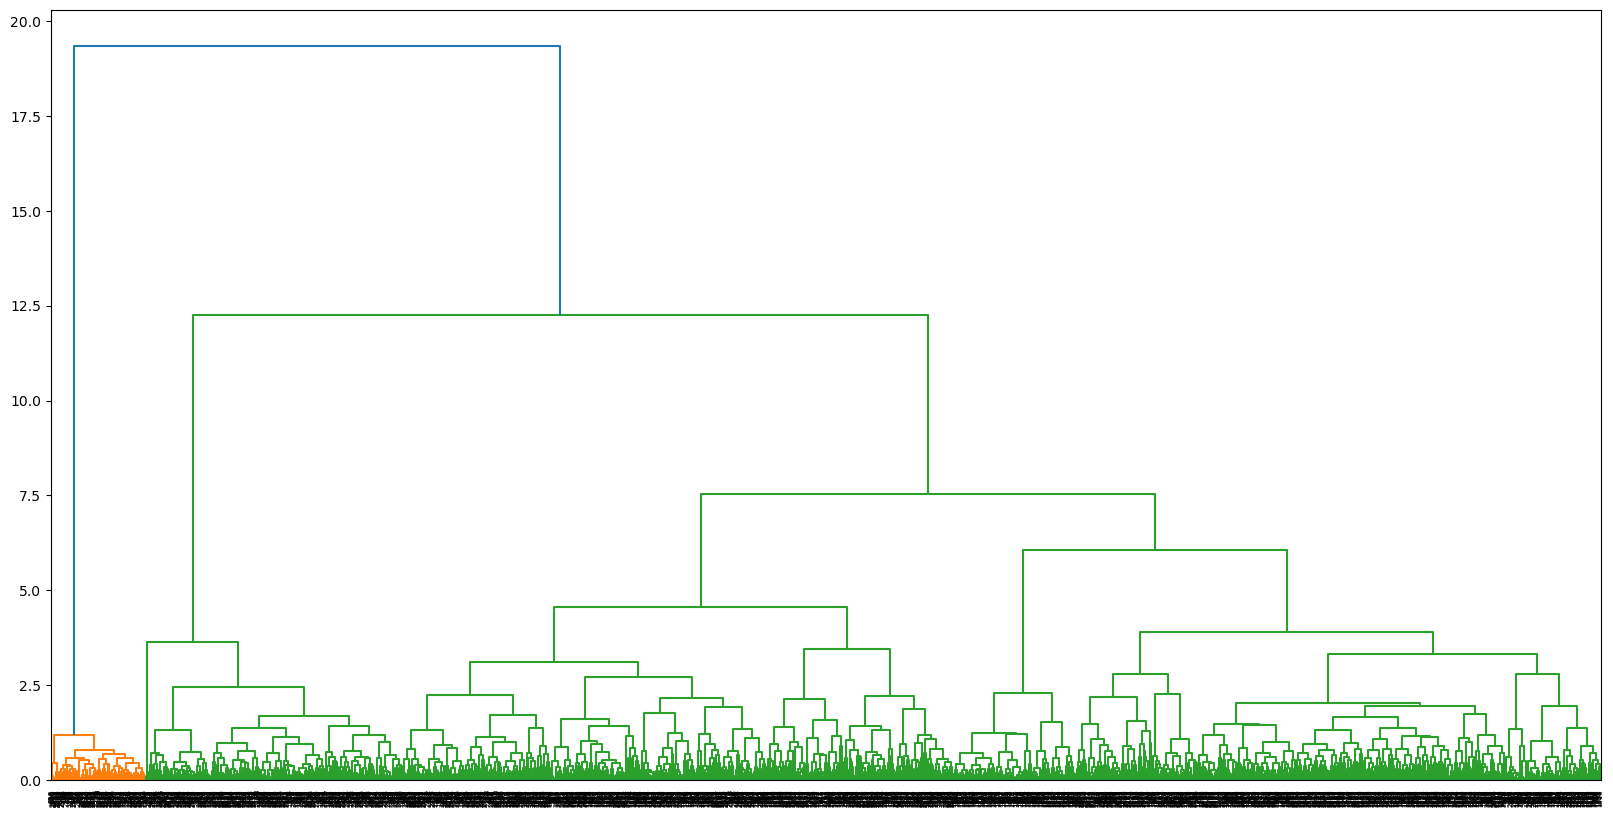

In [34]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax)

In [41]:
clusters = fcluster(linkage_matrix, t=2.5, criterion='distance')

In [42]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# clusters = KMeans(n_clusters=25, max_iter=5000, n_init=300).fit(embedding).labels_

In [43]:
# morh_clusters = results[label]
morh_clusters = region_cluster_labels.values

In [44]:
clusters = pd.Series(clusters, index=component_data.index.values)
clusters = clusters.loc[morh_clusters].values

In [45]:
# assert clusters.shape == results[label].shape

# for i in np.unique(results[label]):
#     idxs = np.where(results[label] == i)[0]
#     old_clusters = results[label][idxs]
#     new_clusters = clusters[idxs]
#     assert np.unique(old_clusters).shape[0] == 1
#     assert np.unique(new_clusters).shape[0] == 1
    

In [46]:
np.unique(clusters, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int32),
 array([  200,   118,  4150, 34921, 19388, 26557, 21573, 29393, 32442,
        19587, 11165, 83548,  2108, 13914]))

In [47]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 4.81 s, sys: 395 ms, total: 5.21 s
Wall time: 5.2 s


In [48]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [49]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [44]:
# clrs_geometry = tessellation.loc[region_cluster_labels.index]
# clrs_geometry['label'] = clusters
# clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
# clrs_geometry.columns = ['geometry']
# clrs_geometry = clrs_geometry.set_geometry('geometry')

In [45]:
# clrs_geometry.explore(column=clrs_geometry.index.values.astype(str), categorical=True)

In [231]:
clrs_geometry.to_parquet(f'../data/clusters__umap_{region_id}_{min_cluster_size}.pq')

In [51]:
from clustergram import Clustergram
from sklearn.mixture import GaussianMixture

In [52]:
component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]
component_data.shape

(166757, 126)

In [151]:
component_data = preprocess_clustering_data(component_data)
component_data.shape

(60555, 54)

In [ ]:
%%time
gmm = GaussianMixture(n_components=10, 
                      covariance_type="full",
                      max_iter=200, 
                      n_init=100,
                      random_state=42)
fitted = gmm.fit(component_data)
clusters = fitted.predict(component_data)
pd.Series(clusters, index=component_data.index).to_csv('../data/gmm_10_clusters.csv')

In [659]:
clusters = pd.read_csv('../data/gmm_10_clusters.csv').set_index('Unnamed: 0')